In [43]:
### IMPORTS
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [44]:
### FUNCTIONS
def winsorize(data,p):              ###INCOMPLETE XXXX
    p = p*0.01
    data_winsorized = np.copy(data)
    data_winsorized[data_winsorized < np.percentile(data, p*100)] = np.percentile(data, p*100)
    data_winsorized[data_winsorized > np.percentile(data, 100-p*100)] = np.percentile(data, 100-p*100)
    return 0

def partition_by_criteria(data,criteria):
    criteria_groups = data.groupby(criteria)   # Group the dataframe by subject_id

    # Create a dictionary of dataframes, one for each value in the criteria column
    partitions = {criteria: criteria_groups.get_group(criteria) for criteria in criteria_groups.groups}
    
    # Return the dictionary of partitions
    return partitions



In [45]:
#INSTANCIATIONS & READING DATA & PREPROCESSING


# scaler = StandardScaler()

## reading test data
subject_id_test = pd.read_csv('Test/subject_id_test.txt')               #test subject
subject_id_test.columns = (['subject_id'])

test_data = pd.read_csv('Test/X_test.txt',delimiter=' ')                #test data

# test_data = pd.DataFrame(scaler.fit_transform(test_data))               #standardise data

test_data.columns = (['feature_' + str(i) for i in range(1, 562)])      #column names

test_labels = pd.read_csv('Test/y_test.txt')                            #test labels
test_labels.columns = (['labels'])

## reading training data
subject_id_train = pd.read_csv('Train/subject_id_train.txt')            #training subject
subject_id_train.columns = (['subject_id'])

train_data = pd.read_csv('Train/X_train.txt',delimiter=' ')             #training data

# train_data = pd.DataFrame(scaler.fit_transform(train_data))             #standardise data

train_data.columns = (['feature_' + str(i) for i in range(1, 562)])     #column names

train_labels = pd.read_csv('Train/y_train.txt')                         #training labels
train_labels.columns = (['labels'])


train_data.head(10)

entire_data = pd.concat([subject_id_train,train_data,test_labels], axis=1)
entire_data

# train_data.describe()

,subject_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_553,feature_554,feature_555,feature_556,feature_557,feature_558,feature_559,feature_560,feature_561,labels
0,1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,...,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,5.0
1,1,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,...,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,5.0
2,1,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,...,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,5.0
3,1,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,...,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,5.0
4,1,0.038988,0.004109,-0.017340,-0.997438,-0.993485,-0.996692,-0.997522,-0.993494,-0.996916,...,-0.554902,-0.844224,0.082632,-0.143439,0.275041,-0.368224,-0.849927,0.184795,-0.035326,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7761,30,0.048048,-0.042445,-0.065884,-0.195448,-0.278326,-0.219954,-0.282233,-0.305861,-0.357803,...,-0.596760,-0.879026,-0.190437,0.829718,0.206972,-0.425619,-0.792292,0.238580,0.056020,NaN
7762,30,0.037639,0.006430,-0.044345,-0.235372,-0.302680,-0.232843,-0.322483,-0.354464,-0.345592,...,-0.404418,-0.684496,0.064907,0.875679,-0.879033,0.400219,-0.772288,0.252653,0.056252,NaN
7763,30,0.037451,-0.002724,0.021009,-0.218281,-0.378082,-0.076950,-0.304446,-0.400661,-0.193071,...,0.000207,-0.317314,0.052806,-0.266724,0.864404,0.701169,-0.779566,0.249121,0.047071,NaN
7764,30,0.044011,-0.004536,-0.051242,-0.219202,-0.383350,-0.081035,-0.310419,-0.380233,-0.201007,...,0.037919,-0.356579,-0.101360,0.700740,0.936674,-0.589479,-0.785603,0.246409,0.031700,NaN


In [46]:
## DATA MANIPULATIONS


## APPLY PCA with 3 features
pca = PCA(n_components=3)
train_data_pca = pd.DataFrame(pca.fit_transform(train_data))
train_data_pca.columns = ['pca_feature_' + str(x) for x in range(3)]


components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

print(train_data_pca)
# print(components)
# print(explained_variance_ratio)

      pca_feature_0  pca_feature_1  pca_feature_2
0         -5.415082      -0.517000      -1.711621
1         -5.368896      -1.026892      -1.836120
2         -5.556865      -1.421823      -1.469504
3         -5.619839      -1.701460      -1.515510
4         -5.593074      -1.948663      -1.350233
...             ...            ...            ...
7761       5.688713       2.145657      -0.595232
7762       5.244134       1.986552      -0.507250
7763       5.259961       2.670647      -0.554205
7764       4.816770       2.918329      -0.680036
7765       4.928907       2.107061      -1.040810

[7766 rows x 3 columns]


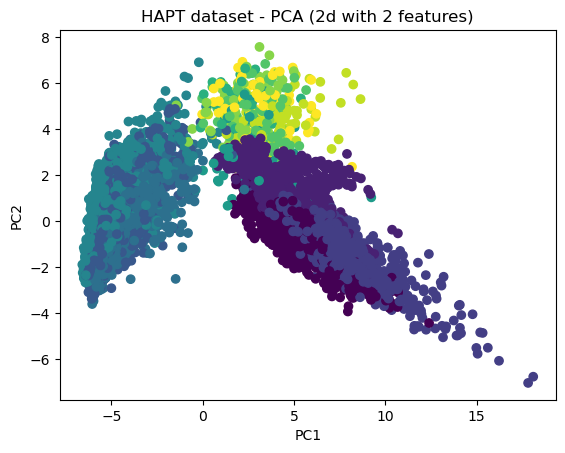

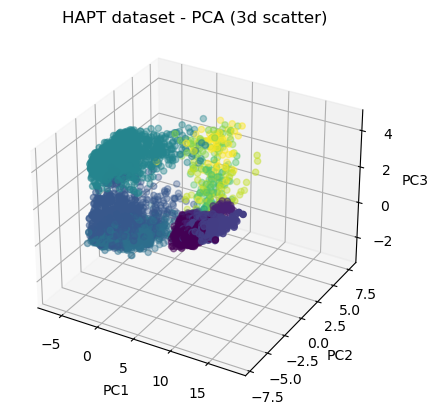

In [47]:
### RANDOM STUFF


# PLOT 1 - HAPT dataset - PCA (2d)

plot = plt.scatter(train_data_pca['pca_feature_0'],
           train_data_pca['pca_feature_1'],
           c=train_labels['labels'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('HAPT dataset - PCA (2d with 2 features)')




# PLOT 2 - HAPT dataset - PCA (3d scatter)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(train_data_pca['pca_feature_0'],
           train_data_pca['pca_feature_1'],
           train_data_pca['pca_feature_2'],
           c=train_labels['labels'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('HAPT dataset - PCA (3d scatter)')
plt.show()



# svm train
# svm = LinearSVC()
# svm.fit(train_data_pca,train_labels)

# print(classification_report(svm.predict(pd.DataFrame(pca.transform(test_data))),test_labels))

In [48]:

### AGGREGATE DATA BY TEST SUBJECT AVERAGES ON A PARTICULAR LABEL ACTION

entire_data_pca = pd.concat([subject_id_train,train_data_pca,test_labels], axis=1)
entire_data_pca


entire_data_clean = pd.concat([subject_id_train,train_data,test_labels], axis=1).dropna()               ### remove rows with missing values
entire_data_pca_clean = pd.concat([subject_id_train,train_data_pca,test_labels], axis=1).dropna()
entire_data_pca_clean

labels_clean_partition = partition_by_criteria(entire_data_pca_clean,'labels')                                                   ### partition the data by labels



# get averages of test subjects on each activity label

def get_partition_avg_by_label(partition):                                                              ### this function returns the average of each pca feature in a partition grouped by labels
    pca1_avg = np.average(partition['pca_feature_0'])                                                   ### essentially a row. to be used where each row represents one label
    pca2_avg = np.average(partition['pca_feature_1'])
    pca3_avg = np.average(partition['pca_feature_2'])
    return pca1_avg, pca2_avg, pca3_avg


labels_clean_averages = []                                                                              ### list which will contain new values (average movement of all users for each movement type/label) to be plotted

for partition in labels_clean_partition.values():                                                       ### adding each row to the list for each label average
    partition = partition.reset_index()                                                                 ### due to the way dataframes work, the index of the partition has to be reset or else it maintains the original index of the 'labels_clean_partition'
    p1,p2,p3 = get_partition_avg_by_label(partition)
    label = partition['labels'][0]                                                                      ### 0 is an arbitrary value but a guaranteed value. every label here has the same value for 'label'
    labels_clean_averages.append([p1,p2,p3,label])

labels_clean_averages = pd.DataFrame(labels_clean_averages)                                             ### convert the list to a dataframe
labels_clean_averages.columns = (['pca_feature_0', 'pca_feature_1', 'pca_feature_2', 'labels'])          ### column names

print(labels_clean_averages)                                                                            ### checking output

    pca_feature_0  pca_feature_1  pca_feature_2  labels
0       -0.133609      -0.009588      -0.257906     1.0
1       -1.266460       0.060514       0.072758     2.0
2       -0.795465       0.356253      -0.037907     3.0
3        1.621457      -0.112011       0.103378     4.0
4        0.800518      -0.190819       0.100408     5.0
5        2.332419      -0.068484      -0.261549     6.0
6        2.169775       0.210637       0.069016     7.0
7        1.047691      -0.572041      -0.725622     8.0
8        2.612566      -0.610657       0.194924     9.0
9        0.388821      -0.226314      -0.194383    10.0
10       1.302091      -0.734597       0.500123    11.0
11      -0.128893      -1.259391      -0.329738    12.0


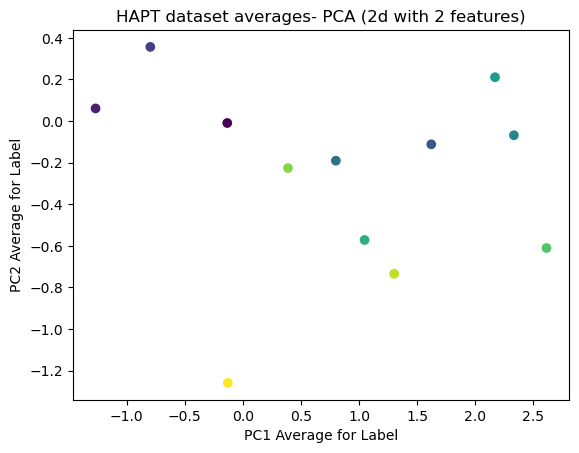

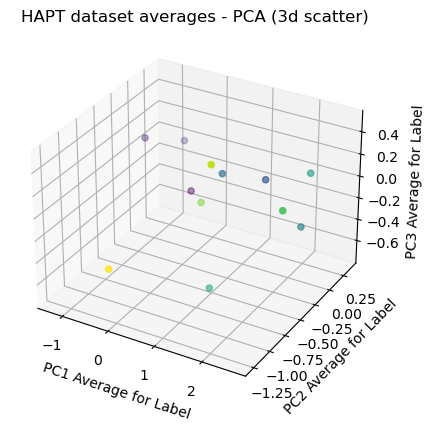

In [49]:
#### PLOTTING THE AVERAGES 


# PLOT 1 - HAPT dataset averages - PCA (2d)

plot = plt.scatter(labels_clean_averages['pca_feature_0'],
           labels_clean_averages['pca_feature_1'],
           c=labels_clean_averages['labels'])
plt.xlabel('PC1 Average for Label')
plt.ylabel('PC2 Average for Label')
plt.title('HAPT dataset averages- PCA (2d with 2 features)')




# PLOT 2 - HAPT dataset - PCA (3d scatter)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(labels_clean_averages['pca_feature_0'],
           labels_clean_averages['pca_feature_1'],
           labels_clean_averages['pca_feature_2'],
           c=labels_clean_averages['labels'])
ax.set_xlabel('PC1 Average for Label')
ax.set_ylabel('PC2 Average for Label')
ax.set_zlabel('PC3 Average for Label')
ax.set_title('HAPT dataset averages - PCA (3d scatter)')
plt.show()